# Code to generate figure 2 part 2 for the paper

In [1]:
# setup all the imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import yaml
import urllib.request
import matplotlib.font_manager
flist = matplotlib.font_manager.get_font_names()
from tempfile import NamedTemporaryFile
import urllib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.patches as patches
from extremeweatherbench import evaluate, utils, cases, defaults
sns.set_theme(style='whitegrid')
from shapely.geometry import Polygon
import shapely
from pathlib import Path
import multiprocessing

# make the basepath - change this to your local path
basepath = Path.home() / 'ExtremeWeatherBench' / ''
basepath = str(basepath) + '/'

In [40]:
# %load /home/amy/ExtremeWeatherBench/docs/notebooks/figure_targets.py
import logging

import numpy as np
import xarray as xr

from extremeweatherbench import inputs, metrics

# Suppress noisy log messages
logging.getLogger("urllib3.connectionpool").setLevel(logging.CRITICAL)
logging.getLogger("botocore.httpchecksum").setLevel(logging.CRITICAL)


def _preprocess_bb_cira_forecast_dataset(ds: xr.Dataset) -> xr.Dataset:
    """An example preprocess function that renames the time coordinate to lead_time,
    creates a valid_time coordinate, and sets the lead time range and resolution not
    present in the original dataset.

    Args:
        ds: The forecast dataset to rename.

    Returns:
        The renamed forecast dataset.
    """
    ds = ds.rename({"time": "lead_time"})
    # The evaluation configuration is used to set the lead time range and resolution.
    ds["lead_time"] = np.array(
        [i for i in range(0, 241, 6)], dtype="timedelta64[h]"
    ).astype("timedelta64[ns]")
    return ds


# GHCN targets
ghcn_heatwave_target = inputs.GHCN(
    source=inputs.DEFAULT_GHCN_URI,
    variables=["surface_air_temperature"],
    variable_mapping={"t2": "surface_air_temperature"},
    storage_options={},
)

# # ERA5 targets
# era5_heatwave_target = inputs.GHCN(
#     source=inputs.ERA5,
#     variables=["surface_air_temperature"],
#     variable_mapping={"t2": "surface_air_temperature"},
#     storage_options={},
# )

era5_heatwave_target = inputs.ERA5(
    source=inputs.ARCO_ERA5_FULL_URI,
    variables=["surface_air_temperature"],
    variable_mapping={
        "2m_temperature": "surface_air_temperature",
        "time": "valid_time",
    },
    storage_options={"remote_options": {"anon": True}},
)

ghcn_freeze_target = inputs.GHCN(
    source=inputs.DEFAULT_GHCN_URI,
    variables=[
        "surface_air_temperature",
        "surface_eastward_wind",
        "surface_northward_wind",
    ],
    variable_mapping={
        "surface_temperature": "surface_air_temperature",
        "surface_eastward_wind": "surface_eastward_wind",
        "surface_northward_wind": "surface_northward_wind",
    },
    storage_options={},
)

# LSR and PPH targets
lsr_target = inputs.LSR(
    source=inputs.LSR_URI,
    variables=["local_storm_reports"],
    variable_mapping={},
    storage_options={"remote_options": {"anon": True}},
)

pph_target = inputs.PPH(
    source=inputs.PPH_URI,
    variables=["practically_perfect_hindcast"],
    variable_mapping={},
    storage_options={"remote_options": {"anon": True}},
)

# IBTrACS target
ibtracs_target = inputs.IBTrACS(
    source=inputs.IBTRACS_URI,
    variables=[
        "surface_wind_speed",
        "air_pressure_at_mean_sea_level",
    ],
    variable_mapping=inputs.IBTrACS_metadata_variable_mapping,
    storage_options={},
)

# Forecast Examples

cira_heatwave_forecast_FOURv2 = inputs.KerchunkForecast(
    source="gs://extremeweatherbench/FOUR_v200_GFS.parq",
    variables=["surface_air_temperature"],
    variable_mapping={"t2": "surface_air_temperature"},
    storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
    preprocess=_preprocess_bb_cira_forecast_dataset,
)

cira_heatwave_forecast_GC = inputs.KerchunkForecast(
    source="gs://extremeweatherbench/GRAP_v100_GFS.parq",
    variables=["surface_air_temperature"],
    variable_mapping={"t2": "surface_air_temperature"},
    storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
    preprocess=_preprocess_bb_cira_forecast_dataset,
)

# cira_freeze_forecast = inputs.KerchunkForecast(
#     source="gs://extremeweatherbench/FOUR_v200_GFS.parq",
#     variables=[
#         "surface_air_temperature",
#         "surface_eastward_wind",
#         "surface_northward_wind",
#     ],
#     variable_mapping={
#         "t2": "surface_air_temperature",
#         "10u": "surface_eastward_wind",
#         "10v": "surface_northward_wind",
#     },
#     storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
#     preprocess=_preprocess_bb_cira_forecast_dataset,
# )

# # Severe convection forecast
# cira_severe_convection_forecast = inputs.KerchunkForecast(
#     source="gs://extremeweatherbench/FOUR_v200_GFS.parq",
#     variables=[],
#     variable_mapping={
#         "t": "air_temperature",
#         "t2": "surface_air_temperature",
#         "z": "geopotential",
#         "r": "relative_humidity",
#         "u": "eastward_wind",
#         "v": "northward_wind",
#         "10u": "surface_eastward_wind",
#         "10v": "surface_northward_wind",
#     },
#     storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
# )

# cira_tropical_cyclone_forecast = inputs.KerchunkForecast(
#     source="gs://extremeweatherbench/FOUR_v200_GFS.parq",
#     variables=[
#         "surface_wind_speed",
#         "air_pressure_at_mean_sea_level",
#     ],
#     variable_mapping={
#         "t": "air_temperature",
#         "t2": "surface_air_temperature",
#         "z": "geopotential",
#         "r": "relative_humidity",
#         "u": "eastward_wind",
#         "v": "northward_wind",
#         "10u": "surface_eastward_wind",
#         "10v": "surface_northward_wind",
#     },
#     storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
# )

FOURv2_GHCN_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=ghcn_heatwave_target,
        forecast=cira_heatwave_forecast_FOURv2, 
    ),
]

FOURv2_ERA5_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=era5_heatwave_target,
        forecast=cira_heatwave_forecast_FOURv2, 
    ),
]

GC_GHCN_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=ghcn_heatwave_target,
        forecast=cira_heatwave_forecast_GC, 
    ),
]

GC_ERA5_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=era5_heatwave_target,
        forecast=cira_heatwave_forecast_GC, 
    ),
]


In [41]:
# load in all of the events in the yaml file
case_dict = utils.load_events_yaml()
heat_test = {"cases": case_dict["cases"]}

ewb_fourv2_ghcn = evaluate.ExtremeWeatherBench(heat_test, FOURv2_GHCN_EVALUATION_OBJECTS)
ewb_fourv2_era5 = evaluate.ExtremeWeatherBench(heat_test, FOURv2_ERA5_EVALUATION_OBJECTS)

ewb_gc_ghcn = evaluate.ExtremeWeatherBench(heat_test, GC_GHCN_EVALUATION_OBJECTS)
ewb_gc_era5 = evaluate.ExtremeWeatherBench(heat_test, GC_ERA5_EVALUATION_OBJECTS)

This function is deprecated and will be removed in a future release. Please use cases.load_ewb_events_yaml_into_case_collection instead.
This function is deprecated and will be removed in a future release. Please use cases.read_incoming_yaml instead.


In [ ]:
heat_test

{'cases': [{'case_id_number': 1,
   'title': '2021 Pacific Northwest',
   'start_date': datetime.datetime(2021, 6, 20, 0, 0),
   'end_date': datetime.datetime(2021, 7, 3, 0, 0),
   'location': {'type': 'centered_region',
    'parameters': {'latitude': 47.6062,
     'longitude': 237.6679,
     'bounding_box_degrees': 5}},
   'event_type': 'heat_wave'},
  {'case_id_number': 2,
   'title': '2022 Upper Midwest',
   'start_date': datetime.datetime(2022, 5, 7, 0, 0),
   'end_date': datetime.datetime(2022, 5, 17, 0, 0),
   'location': {'type': 'centered_region',
    'parameters': {'latitude': 41.8781,
     'longitude': 272.3702,
     'bounding_box_degrees': 5}},
   'event_type': 'heat_wave'}]}

In [ ]:

n_threads_per_process = 4
n_processes = max(1, multiprocessing.cpu_count() // n_threads_per_process)

fourv2_ghcn_results = ewb_fourv2_ghcn.run(parallel=True, n_jobs=n_processes, pre_compute=True)
fourv2_era5_results = ewb_fourv2_era5.run(parallel=True, n_jobs=n_processes, pre_compute=True)

gc_ghcn_results = ewb_gc_ghcn.run(parallel=True, n_jobs=n_processes, pre_compute=True)
gc_era5_results = ewb_gc_era5.run(parallel=True, n_jobs=n_processes, pre_compute=True)


  0%|          | 0/46 [00:00<?, ?it/s]

forecast dataset for case 1 has zero-length dimensions ['valid_time'] for case time range 2021-06-20 00:00:00 to 2021-07-03 00:00:00
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
forecast dataset for case 18 has zero-length dimensions ['valid_time'] for case time range 2021-06-18 00:00:00 to 2021-06-30 00:00:00
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expec

In [5]:
fourv2_era5_results

,value,lead_time,target_variable,metric,target_source,forecast_source,case_id_number,event_type
0,0.145935,0 days 00:00:00,surface_air_temperature,MaximumMAE,ERA5,kerchunk_forecast,1,heat_wave
1,3.667328,0 days 06:00:00,surface_air_temperature,MaximumMAE,ERA5,kerchunk_forecast,1,heat_wave
2,0.925415,0 days 12:00:00,surface_air_temperature,MaximumMAE,ERA5,kerchunk_forecast,1,heat_wave
3,3.930511,0 days 18:00:00,surface_air_temperature,MaximumMAE,ERA5,kerchunk_forecast,1,heat_wave
4,1.012054,1 days 00:00:00,surface_air_temperature,MaximumMAE,ERA5,kerchunk_forecast,1,heat_wave
...,...,...,...,...,...,...,...,...
10381,NaN,9 days 00:00:00,surface_air_temperature,MaxMinMAE,ERA5,kerchunk_forecast,88,heat_wave
10382,NaN,9 days 06:00:00,surface_air_temperature,MaxMinMAE,ERA5,kerchunk_forecast,88,heat_wave
10383,NaN,9 days 12:00:00,surface_air_temperature,MaxMinMAE,ERA5,kerchunk_forecast,88,heat_wave
10384,NaN,9 days 18:00:00,surface_air_temperature,MaxMinMAE,ERA5,kerchunk_forecast,88,heat_wave


In [6]:
gc_ghcn_results

,value,lead_time,target_variable,metric,target_source,forecast_source,case_id_number,event_type
0,1.885016,0 days 00:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,2,heat_wave
1,1.94483,0 days 06:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,2,heat_wave
2,1.961279,0 days 12:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,2,heat_wave
3,2.4401,0 days 18:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,2,heat_wave
4,1.921576,1 days 00:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,2,heat_wave
...,...,...,...,...,...,...,...,...
9509,1.09281,9 days 00:00:00,surface_air_temperature,MaxMinMAE,GHCN,kerchunk_forecast,88,heat_wave
9510,1.410986,9 days 06:00:00,surface_air_temperature,MaxMinMAE,GHCN,kerchunk_forecast,88,heat_wave
9511,1.519446,9 days 12:00:00,surface_air_temperature,MaxMinMAE,GHCN,kerchunk_forecast,88,heat_wave
9512,1.630438,9 days 18:00:00,surface_air_temperature,MaxMinMAE,GHCN,kerchunk_forecast,88,heat_wave


In [43]:
# grab only the maximum MAE results for the heat wave
fourv2_ghcn_group = fourv2_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
fourv2_ghcn_group = fourv2_ghcn_group.reset_index()

fourv2_era5_group = fourv2_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
fourv2_era5_group = fourv2_era5_group.reset_index()

gc_ghcn_group = gc_ghcn_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
gc_ghcn_group = gc_ghcn_group.reset_index()

gc_era5_group = gc_era5_results[['metric', 'lead_time', 'value']].groupby(['metric', 'lead_time']).mean()
gc_era5_group = gc_era5_group.reset_index()



In [34]:
fourv2_ghcn_group[fourv2_ghcn_group['metric'] == 'MaximumMAE']['value'].values

array([3.0742371959377985, 3.4071349106547815, 3.707120340746384,
       3.887300991421245, 3.4236525616964557, 4.027552379049048,
       3.675866011646709, 3.9845270598798406, 3.8760853573634355,
       4.043867433696183, 3.6174999819546416, 4.12997278037587,
       3.7781693530938134, 4.341073040792537, 3.965430100502177,
       4.564128199135171, 4.291281186076305, 4.7961119289063765,
       4.223108890927324, 4.743217699925721, 4.217907418134809,
       4.818832992429442, 4.362876988742062, 4.990545958621778,
       4.631572199043661, 5.160147124333543, 4.6920311498093525,
       5.275629547721481, 4.957966778372817, 5.612110276537784,
       5.383438674269322, 5.6733804022136685, 5.375575030774712,
       5.969693733454368, 5.774654863631604, 6.233282048419025,
       5.935528631573101, 6.292113399562998, 6.264601666706156,
       6.409013937447423, 6.349828320049179], dtype=object)

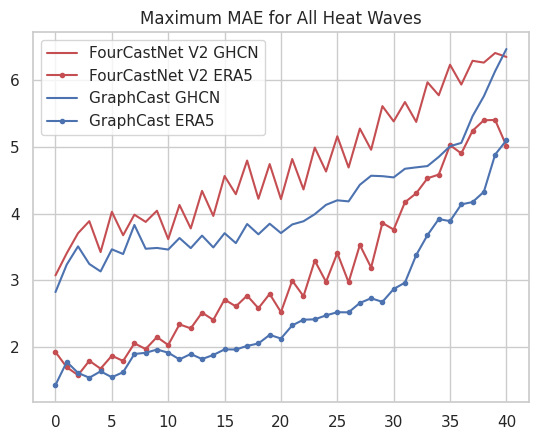

In [45]:
plt.plot(fourv2_ghcn_group[fourv2_ghcn_group['metric'] == 'MaximumMAE']['value'].values, 'r', label='FourCastNet V2 GHCN')
plt.plot(fourv2_era5_group[fourv2_era5_group['metric'] == 'MaximumMAE']['value'].values, 'r.-', label='FourCastNet V2 ERA5')

plt.plot(gc_ghcn_group[gc_ghcn_group['metric'] == 'MaximumMAE']['value'].values, 'b', label='GraphCast GHCN')
plt.plot(gc_era5_group[gc_era5_group['metric'] == 'MaximumMAE']['value'].values, 'b.-', label='GraphCast ERA5')

plt.title('Maximum MAE for All Heat Waves')
plt.legend()